# blm_gauss breaking change (healpy 1.18.1 → 1.19.0)

healpy 1.19.0 changed the Gaussian beam spherical-harmonic coefficients from
`exp(-0.5 * l**2 * sigma^2)` to `exp(-0.5 * l*(l+1) * sigma^2)` to align with
`gauss_beam` and Challinor et al. 2000. This notebook visualizes the difference,
shows percent impacts at representative multipoles, and illustrates how beam
window functions shift for different smoothing scales. The goal: make it easy to
judge whether a pipeline that relied on the old convention needs reprocessing.

## Imports and helpers
We replicate the two formulas directly to avoid any dependency on the installed
healpy version. All arrays are `m=0` (temperature) coefficients; polarization
scaling follows the same exponential factor.

In [1]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np

CURRENT_RELEASE = "1.19.0 (l(l+1))"
PREVIOUS_RELEASE = "1.18.1 (l²)"


@dataclass
class BeamComparison:
    ell: np.ndarray
    blm_old: np.ndarray
    blm_new: np.ndarray
    pct_diff: np.ndarray
    ell_half_power: int
    pct_half_power: float
    pct_extreme: float
    ell_extreme: int


def beam_coefficients(fwhm_rad: float, lmax: int, use_l_lplus1: bool) -> Tuple[np.ndarray, np.ndarray]:
    """Compute m=0 Gaussian beam coefficients using either l^2 or l(l+1)."""
    ell = np.arange(lmax + 1, dtype=float)
    sigma_sq = fwhm_rad * fwhm_rad / (8.0 * math.log(2.0))
    exponent = ell * (ell + 1.0 if use_l_lplus1 else ell)
    prefactor = np.sqrt((2.0 * ell + 1.0) / (4.0 * math.pi))
    bl = prefactor * np.exp(-0.5 * sigma_sq * exponent)
    return ell, bl


def half_power_ell(fwhm_rad: float, lmax: int) -> int:
    """Multipole where the Gaussian damping term drops to 50% of its peak."""
    sigma = fwhm_rad / math.sqrt(8.0 * math.log(2.0))
    target = 2.0 * math.log(2.0) / (sigma * sigma)  # l(l+1) = 2 ln 2 / sigma^2
    ell = int(math.ceil(0.5 * (-1.0 + math.sqrt(1.0 + 4.0 * target))))
    return min(ell, lmax)


def compare_beams(fwhm_rad: float, lmax: int) -> BeamComparison:
    ell, bl_old = beam_coefficients(fwhm_rad, lmax, use_l_lplus1=False)
    _, bl_new = beam_coefficients(fwhm_rad, lmax, use_l_lplus1=True)
    pct_diff = 100.0 * (bl_new - bl_old) / bl_old
    ell_hp = half_power_ell(fwhm_rad, lmax)
    pct_hp = pct_diff[ell_hp]
    extreme_idx = int(np.argmin(pct_diff))
    return BeamComparison(
        ell=ell,
        blm_old=bl_old,
        blm_new=bl_new,
        pct_diff=pct_diff,
        ell_half_power=ell_hp,
        pct_half_power=pct_hp,
        pct_extreme=float(pct_diff[extreme_idx]),
        ell_extreme=int(ell[extreme_idx]),
    )


def beam_window(bl: np.ndarray) -> np.ndarray:
    """Return the usual beam window function B_ell^2."""
    return bl * bl

## Single-beam comparison: 1° FWHM (typical CMB smoothing)
The plots below overlay the old vs new coefficients and show the percent shift.
The marker highlights the half-power multipole: where the Gaussian damping term
reduces the beam to 50% of its zero-mode amplitude. This is a simple, common
way to describe beam width in harmonic space.

FWHM = 60.0 arcmin; ell_half_power = 159; percent change there = -0.436%
Most negative percent change within [0, 2000] = -5.345% at ell = 2000


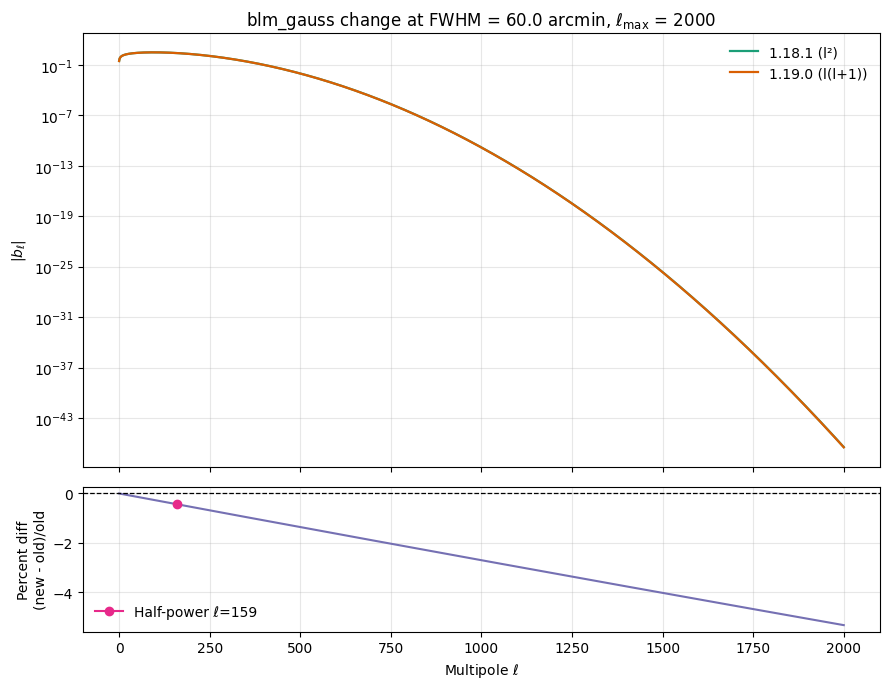

In [2]:
fwhm_arcmin = 60.0
lmax = 2000
fwhm_rad = math.radians(fwhm_arcmin / 60.0)
comparison = compare_beams(fwhm_rad, lmax)

print(
    f"FWHM = {fwhm_arcmin:.1f} arcmin; ell_half_power = {comparison.ell_half_power}; "
    f"percent change there = {comparison.pct_half_power:.3f}%"
)
print(
    f"Most negative percent change within [0, {lmax}] = "
    f"{comparison.pct_extreme:.3f}% at ell = {comparison.ell_extreme}"
)

fig, (ax_top, ax_bottom) = plt.subplots(
    2,
    1,
    figsize=(9, 7),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},
)

ax_top.semilogy(
    comparison.ell,
    comparison.blm_old,
    label=PREVIOUS_RELEASE,
    color="#1b9e77",
    linewidth=1.6,
)
ax_top.semilogy(
    comparison.ell,
    comparison.blm_new,
    label=CURRENT_RELEASE,
    color="#d95f02",
    linewidth=1.6,
)
ax_top.set_ylabel(r"$|b_\ell|$")
ax_top.set_title(rf"blm_gauss change at FWHM = {fwhm_arcmin:.1f} arcmin, $\ell_{{\max}}$ = {lmax}")
ax_top.legend(loc="upper right", frameon=False)
ax_top.grid(alpha=0.3)

ax_bottom.plot(
    comparison.ell,
    comparison.pct_diff,
    color="#7570b3",
    linewidth=1.5,
)
ax_bottom.axhline(0.0, color="black", linestyle="--", linewidth=0.9)
ax_bottom.plot(
    [comparison.ell_half_power],
    [comparison.pct_half_power],
    marker="o",
    color="#e7298a",
    label=f"Half-power ℓ={comparison.ell_half_power}",
)
ax_bottom.set_ylabel("Percent diff\n(new - old)/old")
ax_bottom.set_xlabel(r"Multipole $\ell$")
ax_bottom.grid(alpha=0.3)
ax_bottom.legend(loc="lower left", frameon=False)

plt.tight_layout()
plt.show()

## How the window function shifts for different beams
The beam window function is $B_\ell^2$. Here we plot the fractional change of
$B_\ell^2$ for three beam sizes to see how the impact grows with narrowing beams.

/tmp/ipykernel_3614767/797072927.py:10: RuntimeWarning: invalid value encountered in divide
  frac = (beam_window(comp.blm_new) - beam_window(comp.blm_old)) / beam_window(comp.blm_old)


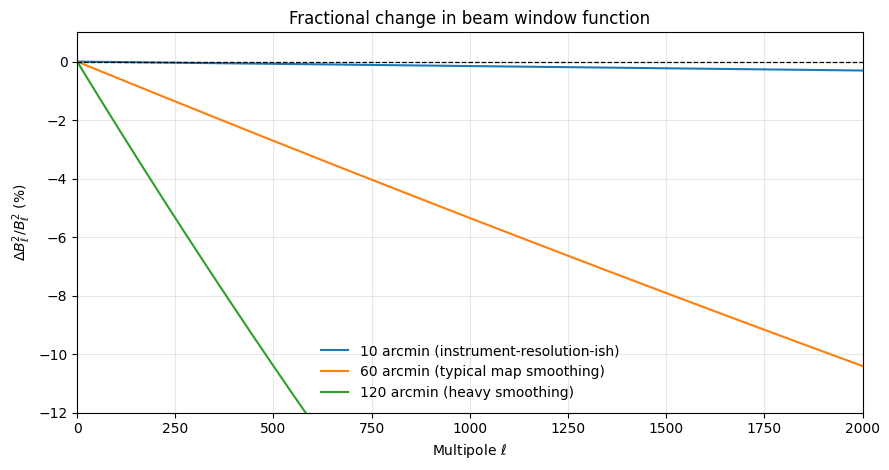

In [3]:
beam_cases = [
    ("10 arcmin (instrument-resolution-ish)", 10.0),
    ("60 arcmin (typical map smoothing)", 60.0),
    ("120 arcmin (heavy smoothing)", 120.0),
]

plt.figure(figsize=(9, 4.8))
for label, fwhm in beam_cases:
    comp = compare_beams(math.radians(fwhm / 60.0), lmax)
    frac = (beam_window(comp.blm_new) - beam_window(comp.blm_old)) / beam_window(comp.blm_old)
    plt.plot(comp.ell, 100.0 * frac, label=label, linewidth=1.5)

plt.axhline(0, color="black", linestyle="--", linewidth=0.9)
plt.xlim(0, lmax)
plt.ylim(-12, 1)
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$\Delta B_\ell^2 / B_\ell^2$ (%)")
plt.title("Fractional change in beam window function")
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## Effect on a toy power spectrum
To get an intuition for spectra-level impacts, take a simple toy model
$C_\ell = 1/(\ell+1)$: a smooth, monotonically decaying spectrum that avoids
divergence at $\ell=0$ and mimics high-$\ell$ damping without acoustic
features. Applying the two beam windows shows how the change redistributes
power.

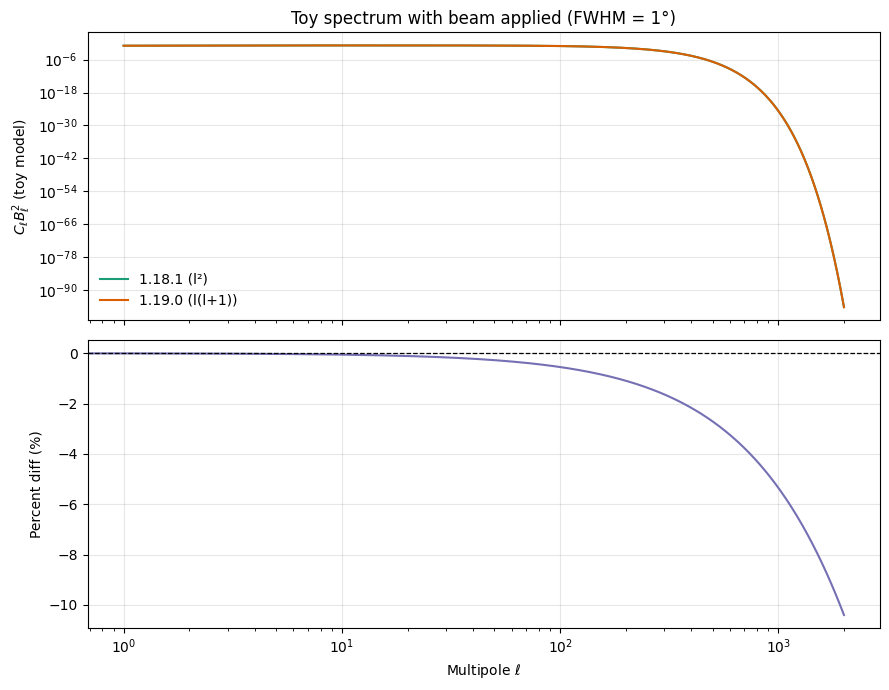

In [4]:
ell = np.arange(lmax + 1, dtype=float)
cl_toy = 1.0 / (ell + 1.0)  # avoids divide-by-zero at ell=0

_, bl_old = beam_coefficients(fwhm_rad, lmax, use_l_lplus1=False)
_, bl_new = beam_coefficients(fwhm_rad, lmax, use_l_lplus1=True)

cl_old_beamed = cl_toy * beam_window(bl_old)
cl_new_beamed = cl_toy * beam_window(bl_new)

ratio = (cl_new_beamed - cl_old_beamed) / cl_old_beamed

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

ax0.loglog(ell[1:], cl_old_beamed[1:], label=PREVIOUS_RELEASE, color="#1b9e77")
ax0.loglog(ell[1:], cl_new_beamed[1:], label=CURRENT_RELEASE, color="#d95f02")
ax0.set_ylabel(r"$C_\ell B_\ell^2$ (toy model)")
ax0.set_title("Toy spectrum with beam applied (FWHM = 1°)")
ax0.grid(alpha=0.3)
ax0.legend(frameon=False)

ax1.plot(ell, 100.0 * ratio, color="#7570b3")
ax1.axhline(0, color="black", linestyle="--", linewidth=0.9)
ax1.set_xlabel(r"Multipole $\ell$")
ax1.set_ylabel("Percent diff (%)")
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Where else is `blm_gauss` used?
A quick ripgrep scan in the repository (tests and docs only) shows no other
functions call `blm_gauss` internally; it is exposed as a user-facing helper.
Downstream impacts occur when these coefficients are injected into custom
pipelines (e.g., multiplying custom $C_\ell$ or $a_{\ell m}$ by `blm_gauss`
to apply a Gaussian beam). Those pipelines should regenerate coefficients
under 1.19.0 to stay consistent.

In [5]:
import shutil, subprocess, textwrap

if shutil.which("rg") is None:
    print("ripgrep (rg) is not available in this environment.")
else:
    scan = subprocess.run(
        ["rg", "blm_gauss"],
        cwd="..",
        capture_output=True,
        text=True,
        check=False,
    )
    if scan.returncode not in (0, 1):  # 1 means no matches
        print(f"rg failed with code {scan.returncode}: {scan.stderr}")
    else:
        print(textwrap.dedent(scan.stdout))

## Takeaways
- The new convention damps high-$\ell$ modes more strongly. For a 1° beam,
  the percent change at the half-power multipole is modest (~0.5%), but reaches
  several percent near $\ell_{\max}=2000$.
- Narrow beams (e.g., 10 arcmin) see the largest fractional changes because
  the $\ell(\ell+1)$ factor grows faster than $\ell^2$ at moderate $\ell$.
- Pipelines that multiply custom $C_\ell$ or $a_{\ell m}$ by `blm_gauss`
  should regenerate those coefficients with 1.19.0 to stay consistent with
  `gauss_beam` and the Challinor et al. convention.